# Trees and Ensemble methods

But first...

## Dealing with discrete data: Ordinal and Categorical

Discrete data come in two flavors, *ordinal* and *categorical*:

 - *ordinal data* - can be ordered
    - 'low', 'medium', 'high'
    - 'F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', ..., 'A', 'A+'
    - '1 br', '2 br', '3 br', ...

- *categorical data* - are not ordered
    - 'cat', 'dog', 'parrot', 'hamster'
    - 'faculty', 'staff', 'student'
    - 'never licensed', 'valid permit', 'valid license', 'suspended/expired license'

Using ```sklearn```, we need to convert these categories into numerical values. There are several transforms available, and which we choose depends on the data.

 - [OrdinalEncoder(categories = list_of_lists_of_categories)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - **for ordinal data**. We tell the ordinal encoder the order of the string data using a list (see example below). OrdinalEncoder can be applied to multiple columns at a time. (e.g. ['low','med','high] ---> [0, 1, 2])
    - Ordinal encoding will replace ordered variables into numbers (0,1,2,...) in a single column.
 - [OneHotEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) -  **for categorical data**. one-hot encoding of mutually exclusive categorical variables.
    - One-Hot encoding creates a new feature for each possible value. Each row will have a 1 in a single column and 0 in the others, hence *one hot*.
 - [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)- **for categorical data**. Label encoding is intended to be used only on the label/target y, hence can only be applied to one column at a time. 

We can apply different transforms to different columns of our data using [ColumnTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Let's look at an example.


In [1]:
import pandas as pd
import numpy as np

grade_roster = dict(
    student_name = ['Alma', 'Barak', 'Connell', 'Devon', 'Eatai', 'Felicia'],
    student_grade = ['A', 'A+', 'B+', 'B', 'C+', 'A'],
    student_major = ['Business', 'Econ', 'Business', 'CS', 'CS', 'Econ']
)

grade_roster_df = pd.DataFrame(grade_roster)
grade_roster_df

,student_name,student_grade,student_major
0,Alma,A,Business
1,Barak,A+,Econ
2,Connell,B+,Business
3,Devon,B,CS
4,Eatai,C+,CS
5,Felicia,A,Econ


In [2]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

grades = ['F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+']
ord_features = ['student_grade']
ordEnc = OrdinalEncoder(categories = [grades])

cat_features = ['student_major']
oneHotEnc = OneHotEncoder()


coltrans = ColumnTransformer(
    transformers=[
        ("ord", ordEnc, ord_features),   # (nickname, transformer object variable, which columns to apply to)
        ("onehot", oneHotEnc, cat_features)
        ],
    remainder = 'passthrough',
    verbose_feature_names_out=False)

X_trans = coltrans.fit_transform(grade_roster_df)
X_trans

array([[11.0, 1.0, 0.0, 0.0, 'Alma'],
       [12.0, 0.0, 0.0, 1.0, 'Barak'],
       [9.0, 1.0, 0.0, 0.0, 'Connell'],
       [8.0, 0.0, 1.0, 0.0, 'Devon'],
       [6.0, 0.0, 1.0, 0.0, 'Eatai'],
       [11.0, 0.0, 0.0, 1.0, 'Felicia']], dtype=object)

In [3]:
new_feature_names = coltrans.get_feature_names_out()
new_feature_names

array(['student_grade', 'student_major_Business', 'student_major_CS',
       'student_major_Econ', 'student_name'], dtype=object)

In [4]:
grade_roster_df2 = pd.DataFrame(X_trans, columns = new_feature_names)
grade_roster_df2

,student_grade,student_major_Business,student_major_CS,student_major_Econ,student_name
0,11.0,1.0,0.0,0.0,Alma
1,12.0,0.0,0.0,1.0,Barak
2,9.0,1.0,0.0,0.0,Connell
3,8.0,0.0,1.0,0.0,Devon
4,6.0,0.0,1.0,0.0,Eatai
5,11.0,0.0,0.0,1.0,Felicia


## Decision/Classification Trees

Tree-based models --- Decision/Classification Trees and Regression Trees --- are a family of algorithms that approach classification and regression using a heirarchy of conditional/if-else statements (imagine a flow chart or a game of 20 questions). You might describe tree-based models as human-like in their approach to problem solving. And these models are not only intuitive and interpretable, they are some of the most ubiquitous and powerful algorithms in ML.

We'll start by looking at a cartoon example of a decision tree, this one predicts whether a casual golfer is expected to shoot below or above par on a given outing.

<img src="tree-graphic.jpg" alt="https://www.mastersindatascience.org/wp-content/uploads/sites/54/2022/05/tree-graphic.jpg" width = 600 />

### Anatomy of a tree
- *Decision node* - a binary question that divides the data set
- *Root node* - the top decision node in the tree
- *Leaf node* - a terminal node where the classification is made
- *Parent/Child node* - the node before/after a split
- *Split* - the forks off a node
- *Branch* - all the decision and leaf nodes that spawn from a single up-stream decision

While the cartoon does a good job showing the structure and flow of a decision tree, it's important to clarify an important detail about the nodes.

In the example, some of the nodes are truly categorical questions:
 - "With friends?"
 - "Walk or cart?"

 While others are seemingly subjective. To make the subjective nodes binary, we define the question in terms of inequalities:
  - "Windy?" is ambiguous. Is 2 mph winds windy? 5 mph? 20 mph? Instead we would use an inequality on the feature: wind > 5 mph
  - "Cold?" is similarly ambiguous. So a node splitting on temperature would need to be formulated as an inequality: temp < 50 F


  ### How do we choose what a good condition for a node would be?

  It is preferable for tree-models to have fewer nodes; smaller models are better. And ideally, each leaf node would represent a set of samples that all belonged to the same class, that is to say, if you followed the branches down to that leaf node, your classification would be correct (and this is not always possible). 
  
  Intuitively, what questions might you ask to classify:
   - animals into their classes: Mammals, Birds, Reptiles, Amphibians, and Fish.
   - beers into their types: pilsner, lager, ale, porter, stout
   - movies into hits or flops
   - voters into their political leanings: Liberal, Conservative, Libertarian, Populist, etc.

  Towards this ideal, at each node, we would want a conditional statement that split the set in a way so that the resulting subsets are as homogeneous (mostly or all one class) as possible. This homogeneity is referred to as the "purity" of the node, and there are different ways of quantifying said purity: *Gini Impurity* and *Information Gain*.
  



### Gini Impurity
   *Gini impurity* is the likelihood of randomly misclassifying a randomly selected sample given the distribution of samples in the set; that is, if you randomly select a sample and randomly select a label, Gini impurity is the likelihood of a mismatch. A Gini impurity of zero represents a perfectly homogeneous set (all the same class).

   If using Gini impurity as the criterion, the fitting algorithm will choose conditions to minimize the Gini impurity at each successive split (using a greedy algorithm).
   
   The Gini index for a *sub-node* is:
   
   $$
   I(p) = \sum_{i=1}^M p_i(1-p_i) \\
   = 1- \sum_{i=1}^M p_i^2
   $$
   
   where:
   
   - $i$ is the class index
   - $M$ is the number of classes
   - $p_i$ is the proportion of a given class in the subset.

   The Gini impurity for a split is the sum of the Gini index for each resultant node, weighted by the number of samples in each node.

  $$
  I(p) = \frac{1}{N}\sum_{k=1}^M n_k I_k(p)
  $$
   
  where:
   
   - $N$ is the sample size at the parent node
   - $n_k$ is the sample size at each sub-node

   Example: Dogs, Cat, Mouse classifier.

## Information Gain

*Entropy* in physics quantifies dis-order. Analagously, *entropy* in information theory quantifies uncertainty.

Entropy (H) of a set is defined as:

$$
H(p) = - \sum_{i=1}^M p_i \log(p_i)
$$

What is the entropy if $p_i = 0$ or $p_i = 1$?

When entropy is zero, there is no uncertainity; in the case of a decision tree, the subsample is perfectly homogeneous.

*Information gain* is the reduction of entropy between the parent and child node.

$$
IG(p) = H_{\text{parent}}(p) - \sum H_{\text{children}}(p)
$$

If using Information Gain as the criterion, the fitting algorithm will choose conditions to maximize Information Gain (reduce entropy) at each successive split (using a greedy algorithm).

## Example: Drug prescriptions

For this example, we'll be looking at the drug200 data set (https://www.kaggle.com/datasets/prathamtripathi/drug-classification).

The dataset summarizes the demographics and health condition of 200 patients (Age, sex, blood, pressure, cholesterol, and sodium/potassium ratio) as well as which of five drugs had best results with the patient. The goal is to build a classifier to choose which drug to prescribe to a future patient.

In [5]:
drugs_df = pd.read_csv('https://raw.githubusercontent.com/kvinlazy/Dataset/refs/heads/master/drug200.csv')

In [6]:
display(drugs_df.info())
display(drugs_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


None

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


### Transform (Encode) the data

In [7]:
from sklearn.preprocessing import StandardScaler

y = drugs_df['Drug']
X = drugs_df.drop(columns = 'Drug')

ord_features = ['Sex', 'BP', 'Cholesterol']
ordEnc = OrdinalEncoder(categories = [['M', 'F'], ['LOW', 'NORMAL', 'HIGH'], ['NORMAL', 'HIGH']])


num_features = ['Age', 'Na_to_K']
ss = StandardScaler()

# Encode Features

ct = ColumnTransformer(transformers = [
    ('ord', ordEnc, ord_features),
    ('ss', ss, num_features)
],
                       remainder = 'passthrough',
                       verbose_feature_names_out=False)

X_trans = ct.fit_transform(X)
X_trans

# Encode output

labEnc = LabelEncoder()
y_trans = labEnc.fit_transform(y)


In [8]:
label_names = labEnc.classes_

In [9]:
feature_names = ct.get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns = feature_names)
X_df

,Sex,BP,Cholesterol,Age,Na_to_K
0,1.0,2.0,1.0,-1.291591,1.286522
1,0.0,0.0,1.0,0.162699,-0.415145
2,0.0,0.0,1.0,0.162699,-0.828558
3,1.0,1.0,1.0,-0.988614,-1.149963
4,1.0,0.0,1.0,1.011034,0.271794
...,...,...,...,...,...
195,1.0,0.0,1.0,0.708057,-0.626917
196,0.0,0.0,1.0,-1.715759,-0.565995
197,0.0,1.0,1.0,0.465676,-0.859089
198,0.0,1.0,0.0,-1.291591,-0.286500


### Fit a decision tree model

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size= 0.2)

tree_clf = DecisionTreeClassifier(max_depth = 4)

tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)


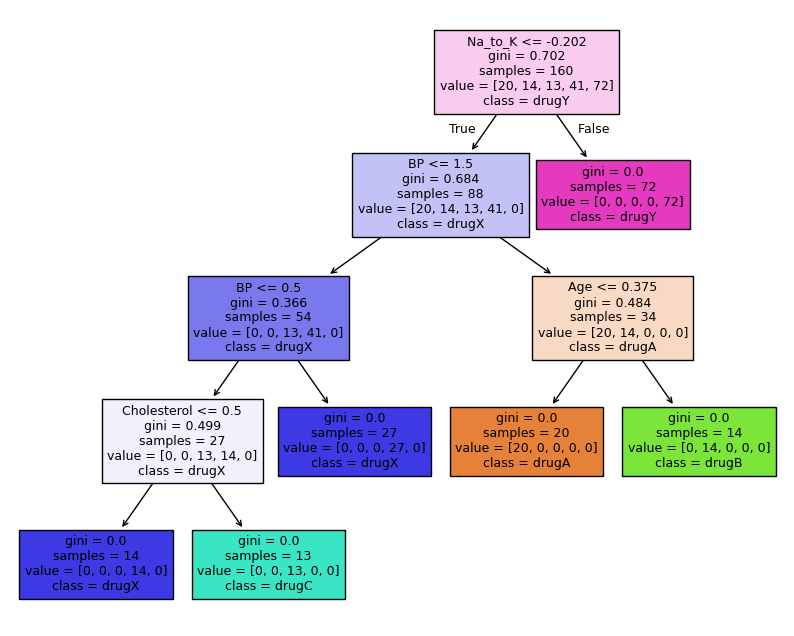

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (10, 8))
plot_tree(tree_clf,
          filled = True, fontsize = 9,
          feature_names = feature_names, class_names = label_names)

plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cfm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cfm, display_labels = class_names).plot()
plt.show()

NameError: name 'class_names' is not defined